![spicy_meme](https://jeinson.github.io/images/mem2.jpg)

<center>Depends who you ask...</center>

# Lab 3: Linear Regression with Stochatic Gradient Descent 

In the previous lab, we introduced auto differentiation, then used gradient descent to maximize the likelihood for simple model parameters. Today, we'll build on this knowledge by implementing linear regression using pytorch's Neural Network package, `torch.nn`. 

To review, in least squares linear regression we have a feature matrix $X$ and a set of corresponding outcomes $Y$, and the goal is to learn a $\beta$ such that $\hat{Y} = X^\top \beta + \epsilon$ minimizes the loss function $\sum_i (Y - \hat{Y})^2$, with $\mathbb{E}[\epsilon] = 0$

In the simple case of one feature and one output (see above meme):

$$ 
Y = 
\begin{bmatrix}
Y_1 \\
Y_2 \\
\vdots \\
Y_n 
\end{bmatrix}  , 
X = \begin{bmatrix}
1 & X_1 \\
1 & X_2 \\
\vdots & \vdots \\
1 & X_n 
\end{bmatrix} ,
\beta = 
 \begin{bmatrix}
\beta_1 \\
\beta_2 
\end{bmatrix}, \text{and } 
\epsilon = 
\begin{bmatrix}
\epsilon_1 \\
\epsilon_2 \\ 
\vdots \\
\epsilon_n
\end{bmatrix}
$$

In $X$, the leading column of 1s allows for an intercept parameter. 

The most common method used for solving linear equations is the **Method of Least Squares**. This is what popular packages like scikit learn or R's `lm` function are doing under the hood. With some fun matrix algebra, the solution pops out fairly easily. 

$$\begin{align}
X\beta &= Y\\
X^\top X\beta &= X^\top Y \\
(X^\top X)^{-1}X^\top X \beta&= (X^\top X)^{-1} X^\top Y \\
&\implies \\
\hat{\beta}&= (X^\top X)^{-1} X^\top Y
\end{align}
$$

This solution involves taking the inverse of a matrix, which gets computationally very expensive as the size of your dataset increases. Therefore, we can think of the problem of optimizing $\beta$ in terms of the machine learning workflow discussed in class, where essentially, we try to mimize the quantity $Q$ in 
$$ (X^\top \beta -  Y)^\top (X^\top \beta - Y) = Q $$
The matrix calculus needed to find an optimal solution to this equation is pretty ugly, but fortunately we can use autodifferentiation and gradient descent to arrive at an optimal solution. 

In [18]:
# Import the following packages. These are the only ones needed to complete the lab. 
# -.5 for using any other packages
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

## Part 1: Simulate some data

Using torch tensors, randomly draw a `[2 x 1] `$\beta$ vector, and 500 random $X_i$s for training. Then matrix multiply $X$ and $\beta$, and add some Gaussian noise, to make a $Y$ vector. This will be the training set used for training your regression model.

In [25]:
#### your code here ####

n = 50

beta = torch.randn(2,1)

X_train = torch.cat((torch.ones(n,1), torch.randn(n,1) * 10), 1)
Y_train = X_train.mm(beta) + (torch.randn(n, 1) / 2)

Plot X and Y to verify their linear relationship. 

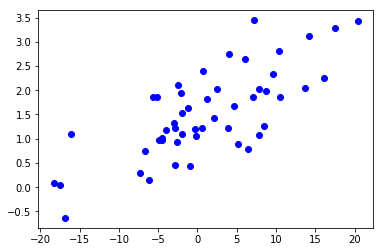

In [26]:
#### your code here ####
plt.plot(X_train.numpy()[:,1], Y_train.detach().numpy()[:,0], 'bo')

## Part 2: Solve Ordinary Least Squares

Using the formula derived in the introduction, find the least squares solution for your sample dataset. 

In [27]:
#### your code here ####
OLS = torch.inverse(X_train.t().mm(X_train)).mm(X_train.t()).mm(Y_train)
OLS = OLS.numpy()

Now plot a trend line on your data using your least squares estimate. 

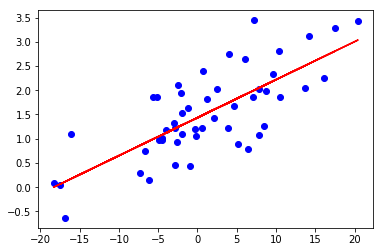

In [28]:
def OLS_line(x):
    return(OLS[0] + x*OLS[1])

plt.plot(X_train.numpy()[:,1], Y_train.detach().numpy()[:,0], 'bo')
plt.plot(X_train.numpy()[:,1], OLS_line(X_train[:,1].numpy()), c='r')

## Part 3: Defining the model as a neural network

In pytorch, neural networks are are typically defined by defining a class. 

Fill in the missing pieces to make a neural network class called `LinearRegression` .

In [29]:
class LinearRegression(nn.Module):
    
    # The class constructor defines the parameters (ie layers) of the neural network
    def __init__(self):
        super(LinearRegression, self).__init__()
        # What type of parameters do we need to add?
        #### your code here ####
        self.linear = nn.Linear(1,1)    
    
    # The forward method ties the layers together to build the network.
    # We take the gradient of this composite function using back propogation
    def forward(self, x):
        #### your code here ###
        out = self.linear(x)
        return(out)

Before training, the model initializes with random parameters. Define a new LinearRegression object, and print the values of the parameters. 

In [30]:
#### your code here ####
lr_model = LinearRegression()

The next step is defining a loss function, which our model will attempt to miminize during training, and an optimization function, which specifies the learning method and learning rate. The most commonly used optimizer is **Stochastic Gradient Descent**, which is conveniently implemented as `torch.optim.SGD`. More on this [here](https://pytorch.org/docs/stable/optim.html). Which loss function should you use to optimizer the parameters in linear regression? [Check here for some options](https://pytorch.org/docs/stable/nn.html#loss-functions)

Define a loss object called `criterion` and an optimizer object called `optimizer`, for the parameters of your new `LinearRegression` object, and with a learning rate of .01. (You may have to play around with the learning rate if your model diverges off to infinity)

In [31]:
#### your code here ###
criterion = torch.nn.MSELoss(size_average = False)
optimizer = torch.optim.SGD(lr_model.parameters(), lr = .0001, momentum = 0.9)

Finally, let's train the model. This is where the magic happens! In training, we iterate through the process of choosing parameters, calculating the loss, then marching down the gradient until the parameters converge. 

In [32]:
print(Y_train.shape)
print(X_train.shape)

torch.Size([50, 1])
torch.Size([50, 2])


In [33]:
epochs = 200

for epoch in range(epochs):
        
    # Estimate Y_hat with the current model
    X_train_new = X_train[:,1:]
    
    Y_hat = lr_model.forward(X_train_new)#[:,1:])
    
    # Compute the loss
    loss = criterion(Y_hat, Y_train)
        
    # Compute the gradient of the loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print("loss {}, beta 1 {}".format(loss,list(lr_model.parameters())[1].detach().numpy()))

loss 2926.052001953125, beta 1 [-0.5519179]
loss 1186.0472412109375, beta 1 [0.29193488]
loss 408.5664978027344, beta 1 [1.2513474]
loss 142.5032196044922, beta 1 [1.6998252]
loss 54.806766510009766, beta 1 [1.6960068]
loss 26.068218231201172, beta 1 [1.5440202]
loss 18.92707061767578, beta 1 [1.4250222]
loss 17.786710739135742, beta 1 [1.390418]
loss 17.606290817260742, beta 1 [1.4039302]
loss 17.568660736083984, beta 1 [1.4271687]
loss 17.570127487182617, beta 1 [1.439682]
loss 17.566755294799805, beta 1 [1.4412956]
loss 17.55948829650879, beta 1 [1.4380864]
loss 17.555095672607422, beta 1 [1.4350972]
loss 17.5532283782959, beta 1 [1.4339525]
loss 17.552412033081055, beta 1 [1.4341085]
loss 17.552082061767578, beta 1 [1.4346409]
loss 17.551979064941406, beta 1 [1.43498]
loss 17.551952362060547, beta 1 [1.43506]
loss 17.551944732666016, beta 1 [1.4349978]


In [35]:
predicted = lr_model(X_train[:,1:])

Now plot the dataset with a trend line defined by the parameters your neural network learned, in addition to the OLS trend line, and label which is which. Try setting the alpha if they end up right on top of each other. 

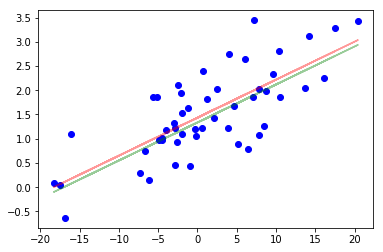

In [38]:
plt.plot(X_train.numpy()[:,1], Y_train.numpy()[:,0], 'bo')
plt.plot(X_train.numpy()[:,1], predicted.t().detach().numpy()[0] - .1, c = "g", alpha = .4)
plt.plot(X_train.numpy()[:,1], OLS_line(X_train[:,1].numpy()), c='r', alpha = .4)

Pretty cool huh? I'll leave it up to you to decide which method you like better, but hopefully this demonstrates the flexibility of a neural network. Later on, we'll see how this package can be used to learn far more complicated patterns in data. 